## Example for turning annotations into regressors

This is a quick example of how to turn our annotations into something that can be used in GLM analyses

In [1]:
# Set up env
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import compute_regressor

sns.set_theme()

In [2]:
# Utility functions for getting stuff from excel sheet

def _load_feature_names():
    # quick and dirty function for getting numerical social interaction columns from excel sheet
    txt_file = './social_interaction_features.txt'
    with open(txt_file, 'r') as file:
        col_names = file.readlines()
    
    temp = []
    for col in col_names:
        x = col.replace('\n', '') # remove newline from extraction
        temp.append(x)
    return temp

def get_features(data_path=None, sheet_name=None):
    if data_path is None:
        data_path = './GOT Features.xlsx' # hard-coding path for testing

    if sheet_name is None:
        sheet_name = 'true false transposed' # hard-coding a set of features for testing
    feat_df = pd.read_excel(data_path, sheet_name=sheet_name)
    # print(feat_df.columns)
    # print(feat_df.head())

    # Get social interaction columns
    feat_names = _load_feature_names()
    data_df = feat_df[feat_names]
    # print(data_df.head())
    # print(data_df.shape)
    return data_df
    

In [3]:
# Load data
social_interaction_features = get_features()

raw_colnames = social_interaction_features.columns
print(raw_colnames)

Index(['social interaction (1) 2 or more living beings interacting',
       'Whether a person speaks in the scene (yes = 1, no = 0)',
       'Characters talking about themselves participating in communication (lines with I/you—‘You must be an army doctor’) (yes = 1, no = 0)',
       'Characters talking about other characters who are not part of communication (lines with he/she/they/other character’s names—‘Yeah, he’s always like that’) (yes = 1, no = 0)',
       'Characters talking about things (lines with it/object name—‘On the desk there is a number.) (yes = 1, no = 0)',
       '(Presence of inter-person actions = 1, absence = 0)', 'valence (1-9)',
       'arousal (1-9)'],
      dtype='object')


In [4]:
# Get second feature - presence or absence of speech
feature_of_interest = raw_colnames[1]
annotation_speech = social_interaction_features.loc[:, feature_of_interest]

print(annotation_speech.head(n=10))

0    0
1    1
2    0
3    1
4    0
5    0
6    1
7    1
8    1
9    0
Name: Whether a person speaks in the scene (yes = 1, no = 0), dtype: int64


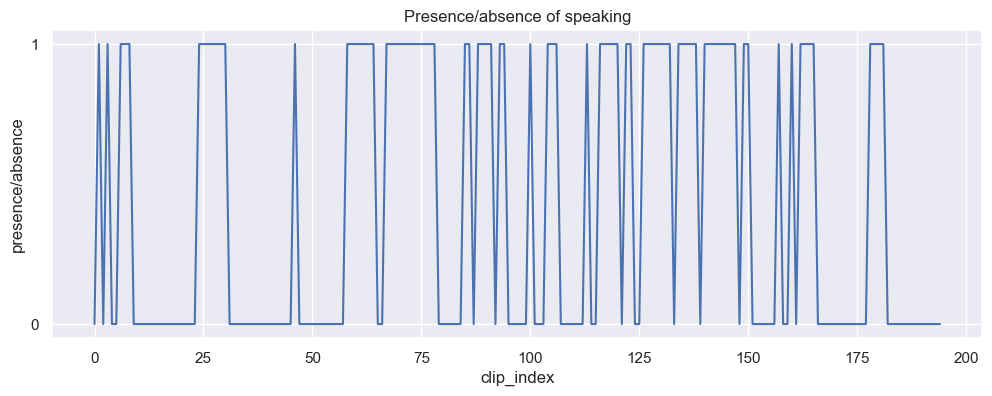

In [5]:
# Plot annotation data for reference
x = annotation_speech.index.values
y = annotation_speech.values

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x, y)
ax.set_xlabel('clip_index')
ax.set_ylabel('presence/absence')
ax.set_yticks([0, 1])
ax.set_title('Presence/absence of speaking')
plt.show()

This is a visual of the annotation for the "Presence/absence of speaking" feature. The x-axis indicates the clip number. Clips were 4 seconds long, with the last clip being 2 seconds long. So each point on the x-axis actually represents an annotation over a 4-second period. First, we should resample these annotations to something that is in 1 second format.

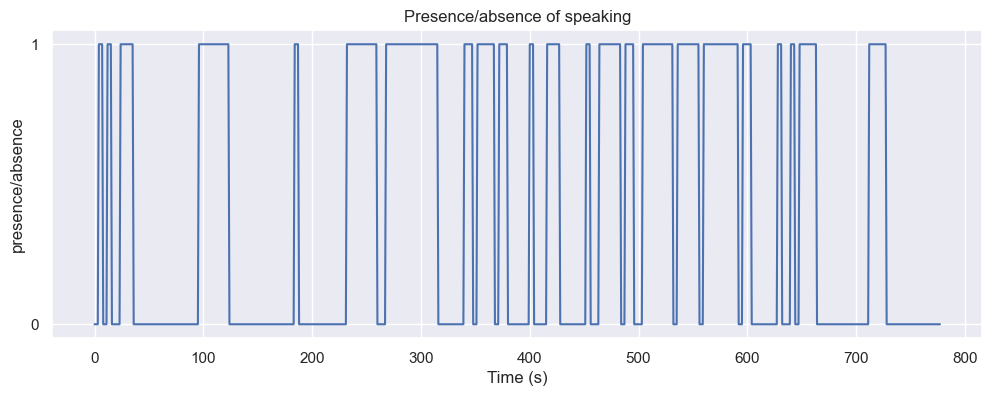

In [6]:
# Convert annotation into a timeseries that spans the length of the movie for reference

n_seconds = 778 # movie is 778s long
x_in_seconds = np.arange(0, n_seconds) # For plotting purposes

y_in_seconds_raw = np.repeat(y, 4) # convert 4-second-clip annotations into 1 second intervals
y_in_seconds = y_in_seconds_raw[:n_seconds] # account for the last clip being 2 seconds long

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_in_seconds, y_in_seconds)
ax.set_xlabel('Time (s)')
ax.set_ylabel('presence/absence')
ax.set_yticks([0, 1])
ax.set_title('Presence/absence of speaking')
plt.show()

Now that the annotation has been resampled to 1 second intervals, we can convolve it with an HRF (here we'll use the default 'spm' HRF) to make a regressor.

(389, 1)


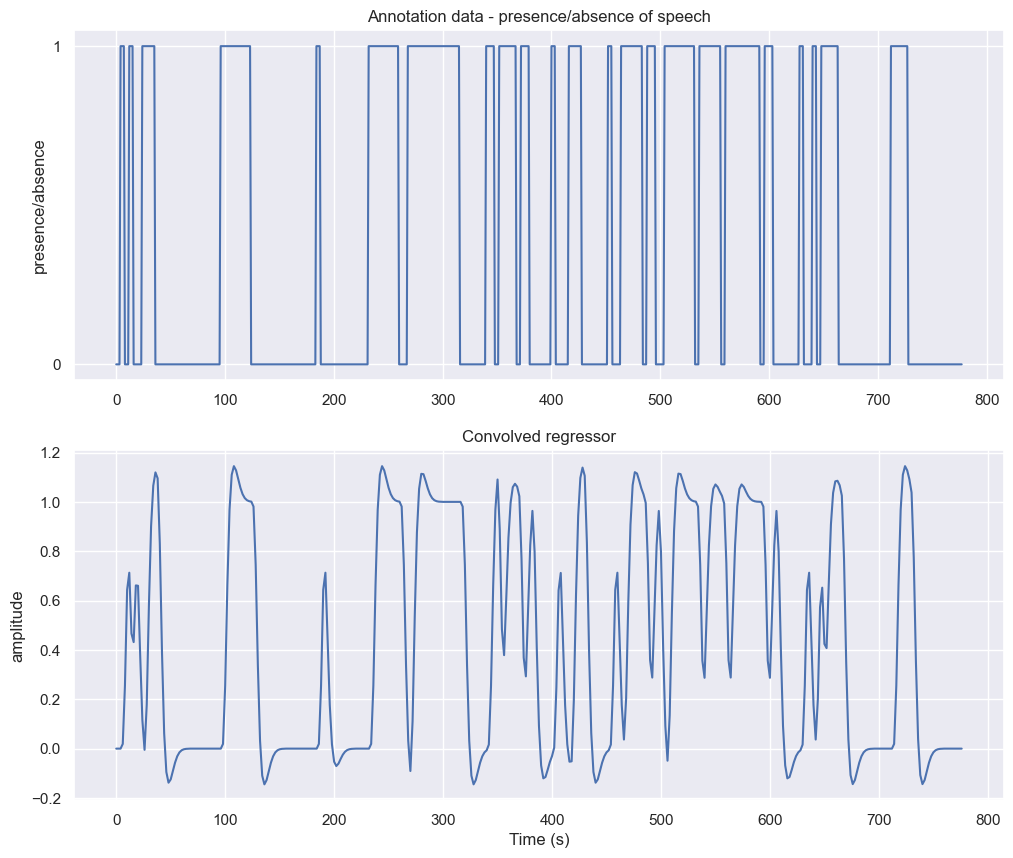

In [ ]:
# Convert this timeseries into a format that nilearn's compute_regressor() function can use
# Requires onset/duration/amplitude arrays (usually specified from timing files in experimental designs)

# In our annotation data, find where data > 0 (presence of speech)
onsets = np.where(y_in_seconds > 0)[0].astype(float)

# After finding the onset times for the annotations, we'll create a "durations" array of the same length, and set them all to 1 second
durations = np.ones_like(onsets) # duration is 1 second since annotations were converted from 4 seconds to 1 second

# Since the annotation is a binary feature, we can set the presence amplitude to 1
amplitudes = np.ones_like(onsets) # set amplitue to 1 since this is a binary feature

# Create exp_condition variable using newly created onset/duration/amplitude data
exp_condition_1 = (onsets, durations, amplitudes)

tr = 2 # fmri data has a TR of 2s
n_scans = 389 # 389 timepoints in fmri data (389*2=778s)
frame_times = np.arange(n_scans) * tr

# Compute a convoled regressor
regressor_1, _ = compute_regressor(exp_condition=exp_condition_1, frame_times=frame_times, hrf_model='spm')
print(regressor_1.shape)

# Plot results!
fig, axs = plt.subplots(nrows=2, figsize=(12, 10))
axs[0].plot(x_in_seconds, y_in_seconds)
axs[0].set_xlabel('')
axs[0].set_ylabel('presence/absence')
axs[0].set_yticks([0, 1])
axs[0].set_title('Annotation data - presence/absence of speech')

axs[1].plot(frame_times, regressor_1[:, 0])
axs[1].set_ylabel('amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Convolved regressor')
plt.show()

This is how we can convolve the annotation data with a HRF to create a regressor. For illustrative purposes, I resampled the annotation data into 1 second intervals before convolving the data - however, it's not necessary to do that with a little logic and coding magic.

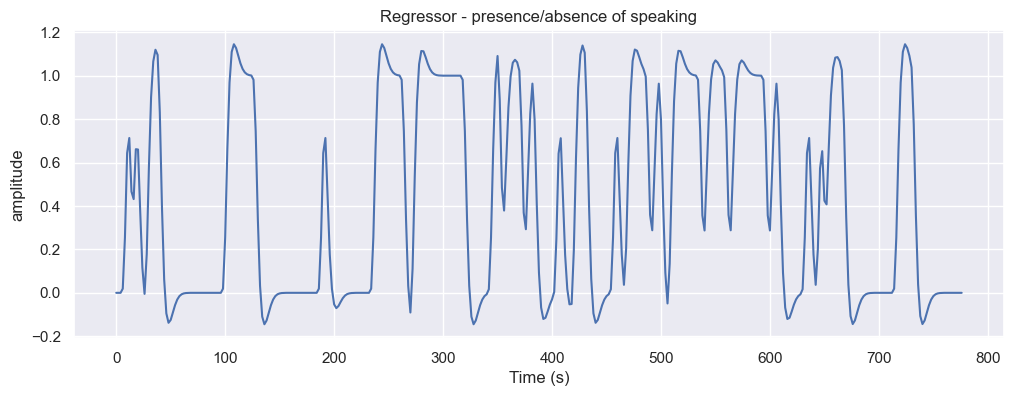

True


In [8]:
# Do the same thing, but without resampling the annotation data into 1 second intervals

# Set data variables again for memory purposes
annotation_speech = social_interaction_features.loc[:, feature_of_interest]
x = annotation_speech.index.values # start point of clips
y = annotation_speech.values # annotation data

clip_len = 4 # clips are 4 seconds long

# create an "onset" array by multiplying the start point of each clip by 4
onsets = x * clip_len

# create a "duration" array that is filled with 4s, with the same length of the onset array
durations = [clip_len] * len(onsets)
durations[-1] = 2 # remember to account for the last clip being two seconds long

# the amplitude array is the actual annotation data itself
amplitudes = y

# create the exp_condition variable with this data
exp_condition_2 = (onsets, durations, amplitudes)

# Using the same settings as above
tr = 2 # fmri data has a TR of 2s
n_scans = 389 # 389 timepoints in fmri data (389*2=778s)
frame_times = np.arange(n_scans) * tr

# Compute a convoled regressor
regressor_2, _ = compute_regressor(exp_condition=exp_condition_2, frame_times=frame_times, hrf_model='spm')

# Plot the output for reference - it should be the same as above
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(frame_times, regressor_2[:, 0])
ax.set_ylabel('amplitude')
ax.set_xlabel('Time (s)')
ax.set_title('Regressor - presence/absence of speaking')
plt.show()

# Check if outputs are the same
print(np.array_equal(regressor_1, regressor_2)) # should raise error if outputs are different

In [9]:
# Save the outputs for viewing 

regressor_df = pd.DataFrame(data=regressor_2, columns=['presence/absence of speaking'])
regressor_df.to_csv('./example_regressor_speech.csv')

timing_data = pd.DataFrame(data=exp_condition_2, index=['onset', 'duration', 'amplitude'])
timing_df = timing_data.T
timing_df.to_csv('./example_timing_file_speech.csv')